In [8]:
import json
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import datetime
import matplotlib.dates as mdates

from matplotlib.ticker import MultipleLocator

pd.plotting.register_matplotlib_converters()

In [2]:
def get_input_data(input_filepath):
    with open(input_filepath, "r") as openfile:
        data = json.load(openfile)

    # Overview information
    available_telescopes = data['available_resources']
    semester_details = data['semester_details']

    # Proposal Priorities
    proposals_objects = data['proposals_by_id']

    proposals = { val["id"]: val["tac_priority"] for (key,val) in \
        proposals_objects.items()}

    # Schedule Parameters?
    ## Not really necessary information, I think. Can add later if desired.

    # Request Data
    request_groups = data['json_request_group_list']
    observation_requests = []
    for request in request_groups:
        r = {}
        r['request_name'] = request['name']
        r['ipp'] = request['ipp_value']
        r['request_type'] = request['observation_type']
        r['proposal_name'] = request['proposal']
        r['proposal_priority'] = proposals[r['proposal_name']]
        r['priority_value'] = float(r['proposal_priority']) * float(r['ipp'])
        r['request_id'] = request['id']

        # Observation Details
        individual_requests = request['requests']
            # NOTE:
            # Observation groups in the current dataset only have 1 request each
            # Thus the information for that request has been taken to represent
            # the entire 'group'.
            # This will have to change for cadenced observations.
        if len(individual_requests) > 1:
            print("WARNING: This observation request group has more than one "+\
                "request inside.\nSoftware needs to be redesigned for "+\
                "multi-request groups.")

        details = individual_requests[0]
        r['acceptability_threshold'] = details['acceptability_threshold']
        r['duration'] = details['duration']
        # r['observation_id'] = details['id']
        r['priority_total'] = float(r['priority_value']) * float(r['duration'])
        r["telescope_class"] = details["location"]["telescope_class"]

        # Format observation windows
        windows = []
        for w in details["windows"]:
            windows.append([datetime.datetime.strptime(w["start"], "%Y-%m-%dT%H:%M:%SZ"),
                            datetime.datetime.strptime(w["end"], "%Y-%m-%dT%H:%M:%SZ")])
        
        r["windows"] = windows
    
        r["og_windows"] = details["windows"]

        # Configuration Details
        configurations = []
        for c in details['configurations']:
            config = {}
            config['acquisition_mode'] = c['acquisition_config']['mode']
            config['max_airmass'] = c['constraints']['max_airmass']
            config['min_lunar_distance'] = c['constraints']['min_lunar_distance']
            config['guiding'] = c['guiding_config']['mode']
            config['subrequest_id'] = c['id']
            config['instrument_type'] = c['instrument_type']
            config['config_priority'] = c['priority']
            # Target Information
            target = c['target']
            config['target_name'] = target['name']
            # config['target_ra'] = target.get_ra().degrees
            # config['target_dec'] = target.get_dec().degrees
            config["target_ra"] = target["_ra"]
            config["target_dec"] = target["_dec"]
            # Input instrument configurations as JSON text blocks
            config['instrument_configs'] = c['instrument_configs']
            configurations.append(config)
        r['configurations'] = configurations

        observation_requests.append(r)

    return observation_requests

In [3]:
def convert_windows(windows_list):
    date_fmt = "%Y-%m-%dT%H:%M:%SZ"
    new_list = []
    for w in windows_list:
        start = datetime.datetime.strptime(date_fmt, w.start)
        end = datetime.datetime.strptime(date_fmt, w.end)
        new_list.append([start, end])
    return new_list

def obtain_dataframe(observation_requests):
    requests_df = pd.DataFrame(observation_requests)
    requests_df["request_id"] = requests_df["request_id"].astype(int)
    
    
    

    return requests_df

In [4]:
default_file = "sample_files/sample_input.json"
df = obtain_dataframe(get_input_data(default_file))
df

,request_name,ipp,request_type,proposal_name,proposal_priority,priority_value,request_id,acceptability_threshold,duration,priority_total,telescope_class,windows,og_windows,configurations
0,SN2017cbv_g_Apr15_SN,1.1,NORMAL,NOAO2019B-9990,30,33.00,103,90.0,3481,114873.00,4m0,"[[2019-04-14 23:00:00, 2019-04-16 10:00:00]]","[{'start': '2019-04-14T23:00:00Z', 'end': '201...","[{'acquisition_mode': 'MANUAL', 'max_airmass':..."
1,SN2017cbv_g_Apr15_SN,1.1,NORMAL,NOAO2019B-9990,30,33.00,102,90.0,1321,43593.00,4m0,"[[2019-04-14 23:00:00, 2019-04-16 10:00:00]]","[{'start': '2019-04-14T23:00:00Z', 'end': '201...","[{'acquisition_mode': 'MANUAL', 'max_airmass':..."
2,J08202975-8003259_Apr15_Cha,1.05,NORMAL,NOAO2019B-0991,20,21.00,101,90.0,1413,29673.00,4m0,"[[2019-04-15 23:00:00, 2019-04-17 10:00:00]]","[{'start': '2019-04-15T23:00:00Z', 'end': '201...","[{'acquisition_mode': 'MANUAL', 'max_airmass':..."
3,J08014860-8058052_Apr15_Cha,1.05,NORMAL,NOAO2019B-0991,20,21.00,100,90.0,1413,29673.00,4m0,"[[2019-04-15 23:00:00, 2019-04-17 10:00:00]]","[{'start': '2019-04-15T23:00:00Z', 'end': '201...","[{'acquisition_mode': 'MANUAL', 'max_airmass':..."
4,2M_J12210499-7116493_Apr15_Cha,1.05,NORMAL,NOAO2019B-0991,20,21.00,99,90.0,1053,22113.00,4m0,"[[2019-04-15 23:00:00, 2019-04-17 10:00:00]]","[{'start': '2019-04-15T23:00:00Z', 'end': '201...","[{'acquisition_mode': 'MANUAL', 'max_airmass':..."
5,2M_J12074597-7816064_Apr15_Cha,1.05,NORMAL,NOAO2019B-0991,20,21.00,98,90.0,1413,29673.00,4m0,"[[2019-04-15 23:00:00, 2019-04-17 10:00:00]]","[{'start': '2019-04-15T23:00:00Z', 'end': '201...","[{'acquisition_mode': 'MANUAL', 'max_airmass':..."
6,2M_J12014343-7835472_Apr15_Cha,1.05,NORMAL,NOAO2019B-0991,20,21.00,97,90.0,1713,35973.00,4m0,"[[2019-04-15 23:00:00, 2019-04-17 10:00:00]]","[{'start': '2019-04-15T23:00:00Z', 'end': '201...","[{'acquisition_mode': 'MANUAL', 'max_airmass':..."
7,2M_J12005517-7820296_Apr15_Cha,1.05,NORMAL,NOAO2019B-0991,20,21.00,96,90.0,1413,29673.00,4m0,"[[2019-04-15 23:00:00, 2019-04-17 10:00:00]]","[{'start': '2019-04-15T23:00:00Z', 'end': '201...","[{'acquisition_mode': 'MANUAL', 'max_airmass':..."
8,2M_J11550485-7919108_Apr15_Cha,1.05,NORMAL,NOAO2019B-0991,20,21.00,95,90.0,1413,29673.00,4m0,"[[2019-04-15 23:00:00, 2019-04-17 10:00:00]]","[{'start': '2019-04-15T23:00:00Z', 'end': '201...","[{'acquisition_mode': 'MANUAL', 'max_airmass':..."
9,2M_J11432669-7804454_Apr15_Cha,1.05,NORMAL,NOAO2019B-0991,20,21.00,94,90.0,1413,29673.00,4m0,"[[2019-04-15 23:00:00, 2019-04-17 10:00:00]]","[{'start': '2019-04-15T23:00:00Z', 'end': '201...","[{'acquisition_mode': 'MANUAL', 'max_airmass':..."


In [5]:
df2 = df.explode("windows")
df2[["start", "end"]] = df2["windows"].apply(lambda x: pd.Series([x[0], x[1]]))
timeline_end = df2["end"].max()
timeline_start = df2["start"].min()

td = timeline_end.date() - timeline_start.date()
days = td.days + 1
total_time = days * 60 * 60 * 24
print(total_time)
plot_start = datetime.datetime.combine(timeline_start.date(), datetime.time())
plot_end = plot_start + datetime.timedelta(days=days)
print(plot_start)
print(plot_end)

df2["window_delay"] = df2.apply(lambda r: (r["start"] - plot_start).total_seconds(), axis=1)
df2["window_length"] = df2.apply(lambda r: (r["end"] - r["start"]).total_seconds(), axis=1)

df2

345600
2019-04-14 00:00:00
2019-04-18 00:00:00


,request_name,ipp,request_type,proposal_name,proposal_priority,priority_value,request_id,acceptability_threshold,duration,priority_total,telescope_class,windows,og_windows,configurations,start,end,window_delay,window_length
0,SN2017cbv_g_Apr15_SN,1.1,NORMAL,NOAO2019B-9990,30,33.00,103,90.0,3481,114873.00,4m0,"[2019-04-14 23:00:00, 2019-04-16 10:00:00]","[{'start': '2019-04-14T23:00:00Z', 'end': '201...","[{'acquisition_mode': 'MANUAL', 'max_airmass':...",2019-04-14 23:00:00,2019-04-16 10:00:00,82800.0,126000.0
1,SN2017cbv_g_Apr15_SN,1.1,NORMAL,NOAO2019B-9990,30,33.00,102,90.0,1321,43593.00,4m0,"[2019-04-14 23:00:00, 2019-04-16 10:00:00]","[{'start': '2019-04-14T23:00:00Z', 'end': '201...","[{'acquisition_mode': 'MANUAL', 'max_airmass':...",2019-04-14 23:00:00,2019-04-16 10:00:00,82800.0,126000.0
2,J08202975-8003259_Apr15_Cha,1.05,NORMAL,NOAO2019B-0991,20,21.00,101,90.0,1413,29673.00,4m0,"[2019-04-15 23:00:00, 2019-04-17 10:00:00]","[{'start': '2019-04-15T23:00:00Z', 'end': '201...","[{'acquisition_mode': 'MANUAL', 'max_airmass':...",2019-04-15 23:00:00,2019-04-17 10:00:00,169200.0,126000.0
3,J08014860-8058052_Apr15_Cha,1.05,NORMAL,NOAO2019B-0991,20,21.00,100,90.0,1413,29673.00,4m0,"[2019-04-15 23:00:00, 2019-04-17 10:00:00]","[{'start': '2019-04-15T23:00:00Z', 'end': '201...","[{'acquisition_mode': 'MANUAL', 'max_airmass':...",2019-04-15 23:00:00,2019-04-17 10:00:00,169200.0,126000.0
4,2M_J12210499-7116493_Apr15_Cha,1.05,NORMAL,NOAO2019B-0991,20,21.00,99,90.0,1053,22113.00,4m0,"[2019-04-15 23:00:00, 2019-04-17 10:00:00]","[{'start': '2019-04-15T23:00:00Z', 'end': '201...","[{'acquisition_mode': 'MANUAL', 'max_airmass':...",2019-04-15 23:00:00,2019-04-17 10:00:00,169200.0,126000.0
5,2M_J12074597-7816064_Apr15_Cha,1.05,NORMAL,NOAO2019B-0991,20,21.00,98,90.0,1413,29673.00,4m0,"[2019-04-15 23:00:00, 2019-04-17 10:00:00]","[{'start': '2019-04-15T23:00:00Z', 'end': '201...","[{'acquisition_mode': 'MANUAL', 'max_airmass':...",2019-04-15 23:00:00,2019-04-17 10:00:00,169200.0,126000.0
6,2M_J12014343-7835472_Apr15_Cha,1.05,NORMAL,NOAO2019B-0991,20,21.00,97,90.0,1713,35973.00,4m0,"[2019-04-15 23:00:00, 2019-04-17 10:00:00]","[{'start': '2019-04-15T23:00:00Z', 'end': '201...","[{'acquisition_mode': 'MANUAL', 'max_airmass':...",2019-04-15 23:00:00,2019-04-17 10:00:00,169200.0,126000.0
7,2M_J12005517-7820296_Apr15_Cha,1.05,NORMAL,NOAO2019B-0991,20,21.00,96,90.0,1413,29673.00,4m0,"[2019-04-15 23:00:00, 2019-04-17 10:00:00]","[{'start': '2019-04-15T23:00:00Z', 'end': '201...","[{'acquisition_mode': 'MANUAL', 'max_airmass':...",2019-04-15 23:00:00,2019-04-17 10:00:00,169200.0,126000.0
8,2M_J11550485-7919108_Apr15_Cha,1.05,NORMAL,NOAO2019B-0991,20,21.00,95,90.0,1413,29673.00,4m0,"[2019-04-15 23:00:00, 2019-04-17 10:00:00]","[{'start': '2019-04-15T23:00:00Z', 'end': '201...","[{'acquisition_mode': 'MANUAL', 'max_airmass':...",2019-04-15 23:00:00,2019-04-17 10:00:00,169200.0,126000.0
9,2M_J11432669-7804454_Apr15_Cha,1.05,NORMAL,NOAO2019B-0991,20,21.00,94,90.0,1413,29673.00,4m0,"[2019-04-15 23:00:00, 2019-04-17 10:00:00]","[{'start': '2019-04-15T23:00:00Z', 'end': '201...","[{'acquisition_mode': 'MANUAL', 'max_airmass':...",2019-04-15 23:00:00,2019-04-17 10:00:00,169200.0,126000.0


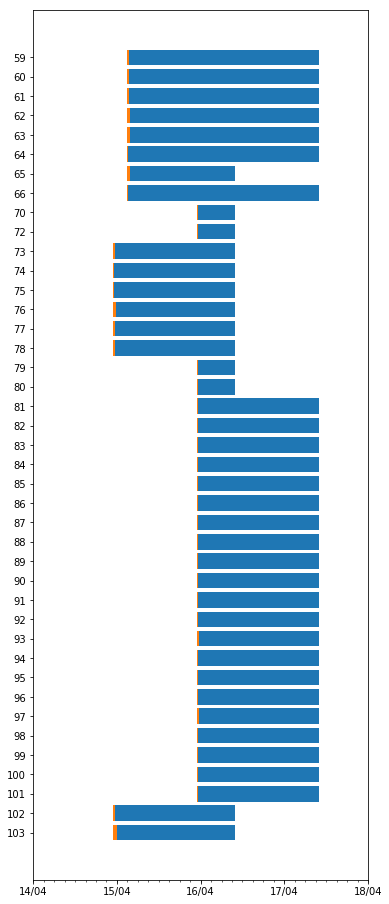

In [11]:
fig, ax = plt.subplots(1, figsize=(6, 16))
ax.barh(df2["request_id"].astype(str), df2["window_length"], left=df2["window_delay"])
ax.barh(df2["request_id"].astype(str), df2["duration"].astype(int), left=df2["window_delay"])

xticks = np.arange(0, days * 60*60*24+1, 60*60*24)
# xticks_minor = np.arange(0, df2["window_length_s"].max().total_seconds(), 1)
xtick_labels = pd.date_range(plot_start, end=plot_end).strftime("%d/%m")
ax.set_xticks(xticks)
# ax.set_xticks()
ax.set_xticklabels(xtick_labels)
plt.xlim([0, total_time])
ax.xaxis.set_minor_locator(MultipleLocator(3*60*60))

plt.show()